This data is from: https://www.kaggle.com/zynicide/wine-reviews. The data's scraped from WineEthusiast and was made available for use on Kaggle.

Continuing on from before, let's try to see if we can predict the wine variety.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
filename = "winemag-data_first150k.csv"
path = "C:/Data/Projects/Wine/"
data = pd.read_csv(path + filename)
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [8]:
data.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


We can immediately see a few things- the cheapest wine is 4 dollars, while the most expensive is 2300 dollars, with the mean price being 33. In terms of points, the worst wine comes in a 80 points, while the best comes in at 100. Even at 80 points I'd say that's pretty high- people like their wine!

# Cleaning #

Let's clean the data. First, let's check if there are any null values in the dataframe.

In [9]:
are_null_values = data.isnull().values.any()
num_nulls = data.isnull().sum()
print("Columns with null values:\n",num_nulls)
print("Number of observations:\n",len(data))

Columns with null values:
 Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64
Number of observations:
 150930


We have 45735 null values for designation, 13695 for price, 25060 for region_1, and 89977 for region_2. That means only about 40% of the data has a region_2 value- I don't want to drop all null values then, or else I'll be getting rid of 60% of my data. I don't think region_2 is that important, since we already have the country, province, and region_1. I'll go ahead and just drop region_2 from the dataframe. Then I'll drop rows that have null values- this will result in losing less data. Let's also drop "Unnamed: 0" since this is just a duplication of the index.

In [10]:
data = data.drop("region_2", axis = 1)
data = data[pd.notnull(data)] # drop if null values
data = data.drop("Unnamed: 0", axis = 1) # drop the first column
data.shape

(150930, 9)

Finally, we want to make sure that every description is unique. Some descriptions may be duplicated, which means a wine has been entered in the dataset twice. Let's ensure that every description appears only once, but first let's check to see if there are duplicates, then drop them accordingly.

In [11]:
data[data.duplicated('description', keep = False)].sort_values('description').head(5)

,country,description,designation,points,price,province,region_1,variety,winery
147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,Chardonnay,La Playa
62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,Chardonnay,La Playa
74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Cabernet Sauvignon,Mauritson
18803,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Cabernet Sauvignon,Mauritson
26530,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,Sauvignon Blanc,Neumeister


In [12]:
data = data.drop_duplicates("description") # drop duplicate descriptions
data["designation"] = data["designation"].str.lower() # make sure all lower
data = data[pd.notnull(data)] # drop null values
data = data[data.price.notnull()] # ensure the price and points rows that are null are dropped
ata = data[data.points.notnull()]
data.shape

(89108, 9)

We also need to ensure that the variety name doesn't occur in the description, so let's add variety name to our list of stop words to remove from the description.

In [13]:
variety_words = set()
for wine_variety in data.variety:
    wine_variety = wine_variety.lower()
    wine_variety = wine_variety.split()
    for word in wine_variety:
        variety_words.add(word)

variety_list = sorted(variety_words)
variety_list[:5]

['agiorgitiko', 'aglianico', 'aidani', 'airen', 'albana']

In [14]:
# Remove stop words
# Set the stop words
from nltk.corpus import stopwords
extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%", "that's"]
stopwords = set(stopwords.words('english'))
stopwords.update(variety_list)
stopwords.update(extras)
# Now remove the stop words
data["description"] = data["description"].apply(lambda x: x.lower())    
data["description"] = data["description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [15]:
data.tail(5)

,country,description,designation,points,price,province,region_1,variety,winery
149634,France,"atypically light body reticent nose, gewürz in...",NaN,84,15.0,Alsace,Alsace,Gewürztraminer,W. Gisselbrecht
149635,US,"dry rustically tannic, gritty, chewy feeling, ...",bungalow red,84,15.0,California,Santa Barbara County,Syrah-Grenache,Casa Barranca
149637,US,"outside vineyard, wines like built company's p...",NaN,84,6.0,California,California,Merlot,Delicato
149638,Argentina,"heavy basic, pineapple aromas. full-flavored t...",NaN,84,9.0,Mendoza Province,Uco Valley,Sauvignon Blanc,Finca El Portillo
149639,Australia,"smooth mouth, chard starts citrus dust aromas ...",NaN,84,8.0,Australia Other,South Eastern Australia,Chardonnay,Jacob's Creek


# Modelling

Let's see if we can determine a wine's price. To start, let's work with the province, description, points, and variety. I won't include country since province includes country. To keep the feature set managebale, I'll exclude region_1, designation, and winery.

So our features are: Description, points, province, variety.

Let's first do our imports.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

We'll use TfidfVectorizor to process the wine descriptions to get Tfidf features. We'll use several linear models: linear regression, ridge regression, lasso, and PCA regression. As it's often useful to standardize variables with linear models, we'll try this too. Our only numerical values really are from the points column, the rest are one hot vectors (from variety and winery), and the Tfidf features as mentioned for the wine descriptions. Our error metrics will be mean square error (the smaller the better), and explained variance score (the closer to 1.0 the better). 

Let's prep the data for our linear models. There's a decent amount of outliers in the data so let's be weary of that.

In [17]:
def prep_data(data, outlier_threshold, remove_outliers = True):
    if remove_outliers:
        data = data[data.price < outlier_threshold]
    else:
        data = data
    X = data.drop(['country','designation','region_1','winery', 'price'], axis = 1)
    y = data.price.astype(float)
    # Tokenize our description before splitting
    tfidf = TfidfVectorizer(min_df = 977) # Ignore terms that appear in less than 1% of samples. this reduces the feature space
    descrip = tfidf.fit_transform(X.description).toarray()
    # One hot encode the provinces and varieties
    provinces = pd.get_dummies(X.province)
    varieties = pd.get_dummies(X.variety)
    # Stack the matrices
    points_ = X.points.values
    X = np.hstack((descrip, provinces, varieties, points_[:,None]))
    return X, y

Time to do some modelling! Let's write some helper functions.

In [21]:
def try_linear_models(X_, y_, model_name, standardize = True):
    if standardize == True:
        X = preprocessing.scale(X_)
    else:
        X = X_
    X_train, X_test, y_train, y_test = train_test_split(X, y_, random_state = 42)
    if model_name == "linear":
        model = linear_model.LinearRegression().fit(X_train, y_train)
    if model_name == "ridge":
        model = linear_model.Ridge(alpha = 0.1).fit(X_train, y_train)
    if model_name == "lasso":
        model = linear_model.Lasso(alpha = 0.5).fit(X_train, y_train)
    if model_name == "pca_reg":
        n_components = 16
        pca = PCA(n_components,svd_solver='randomized',whiten=True).fit(X)
        data = pca.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(data, y_, random_state = 42)
        model = linear_model.LinearRegression().fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions, y_test

In [22]:
def error_metrics(model, predictions, y_test):
    print("Model: ", model)
    # The mean squared error
    print("--Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
    # Explained variance score: 1 is perfect prediction
    print('--Variance score: %.2f' % r2_score(y_test, predictions))

In [23]:
# Take a look at some of the results
def inspect_df(predictions, y_test):
    true_vs_pred = np.vstack((predictions, y_test))
    true_df = pd.DataFrame(true_vs_pred)
    true_df = true_df.transpose()
    true_df.columns = ["Predicted", "Actual"]
    return true_df

In [24]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

With that done, *now* we can do some fun stuff!

In [25]:
# Get model results
# Without removing any outliers
X, y = prep_data(data, outlier_threshold = 0, remove_outliers = False)

# With standardizing
ridge_pred_st, y_test = try_linear_models(X, y, "ridge", standardize=True)
lasso_pred_st, y_test = try_linear_models(X, y, "lasso", standardize=True)
pca_pred_st, y_test = try_linear_models(X, y, "pca_reg", standardize=True)

# Without standardizing
ridge_pred, y_test = try_linear_models(X, y, "ridge", standardize=False)
lasso_pred, y_test = try_linear_models(X, y, "lasso", standardize=False)
pca_pred, y_test = try_linear_models(X, y, "pca_reg", standardize=False)

# Error metrics
error_metrics("Ridge with standardizing", ridge_pred_st, y_test)
error_metrics("Lasso with standardizing", lasso_pred_st, y_test)
error_metrics("PCA regression with standardizing", pca_pred_st, y_test)

error_metrics("Ridge without standardizing", ridge_pred, y_test)
error_metrics("Lasso without standardizing", lasso_pred, y_test)
error_metrics("PCA regression without standardizing", pca_pred, y_test)

Model:  Ridge with standardizing
--Mean squared error: 1015.94
--Variance score: 0.31
Model:  Lasso with standardizing
--Mean squared error: 1045.60
--Variance score: 0.29
Model:  PCA regression with standardizing
--Mean squared error: 1190.58
--Variance score: 0.19
Model:  Ridge without standardizing
--Mean squared error: 1015.03
--Variance score: 0.31
Model:  Lasso without standardizing
--Mean squared error: 1156.22
--Variance score: 0.21
Model:  PCA regression without standardizing
--Mean squared error: 1132.06
--Variance score: 0.23


Seems like ridge regression does the best, both with standardized and non standardized variables. Let's take a quick look at what some of our predictions actually look like.

In [26]:
# Let's look at ridge regression with standardized variables, and without
# LEFT: With standardized variables
# RIGHT: Without
display_side_by_side(inspect_df(ridge_pred_st, y_test).tail(10),inspect_df(ridge_pred, y_test).tail(10))

,Predicted,Actual
22267,20.093576,24.0
22268,5.655745,8.0
22269,23.180856,20.0
22270,13.199893,13.0
22271,101.267411,72.0
22272,-3.431131,10.0
22273,29.570737,36.0
22274,35.777497,50.0
22275,75.795340,60.0
22276,54.749942,75.0


So you can see that our ridge regression for some labels is quite good, but for some is way off! Actually, there are some pretty expensive wines in the dataset. In fact, 99.99 % of the data comes in below 1000 dollars. So let's see how the model performs when we remove these more expensive wines.

In [27]:
# Get model results
# Remove bottles that cost more than 1000 dollars
X, y = prep_data(data, outlier_threshold = 1000.0, remove_outliers = True)
# With standardizing
ridge_pred_st, y_test = try_linear_models(X, y, "ridge", standardize=True)
lasso_pred_st, y_test = try_linear_models(X, y, "lasso", standardize=True)
pca_pred_st, y_test = try_linear_models(X, y, "pca_reg", standardize=True)
# Without standardizing
ridge_pred, y_test = try_linear_models(X, y, "ridge", standardize=False)
lasso_pred, y_test = try_linear_models(X, y, "lasso", standardize=False)
pca_pred, y_test = try_linear_models(X, y, "pca_reg", standardize=False)

# Error metrics
error_metrics("Ridge with standardizing", ridge_pred_st, y_test)
error_metrics("Lasso with standardizing", lasso_pred_st, y_test)
error_metrics("PCA regression with standardizing", pca_pred_st, y_test)
error_metrics("Ridge without standardizing", ridge_pred, y_test)
error_metrics("Lasso without standardizing", lasso_pred, y_test)
error_metrics("PCA regression without standardizing", pca_pred, y_test)

Model:  Ridge with standardizing
--Mean squared error: 748.77
--Variance score: 0.36
Model:  Lasso with standardizing
--Mean squared error: 778.95
--Variance score: 0.33
Model:  PCA regression with standardizing
--Mean squared error: 902.73
--Variance score: 0.22
Model:  Ridge without standardizing
--Mean squared error: 748.38
--Variance score: 0.36
Model:  Lasso without standardizing
--Mean squared error: 879.00
--Variance score: 0.24
Model:  PCA regression without standardizing
--Mean squared error: 857.97
--Variance score: 0.26


Ridge regression still seems to come out on top. Let's take a look at the residual plot. Ideally the residuals will be random about the horizontal line at zero.

(array([-1000.,  -800.,  -600.,  -400.,  -200.,     0.,   200.]),
 <a list of 7 Text yticklabel objects>)

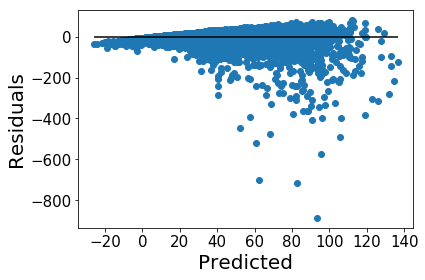

In [35]:
plt.scatter(ridge_pred_st, ridge_pred_st - y_test)
plt.hlines(y= 0, xmin = min(ridge_pred_st), xmax = max(ridge_pred_st))
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Predicted", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

We definitely see some heteroskedasticity going on here. That's not good!

# Conclusion



Overall, how did we do? Honestly, not the best. The fact that the residuals show heteroskedasticity for our "best" result with ridge regression shows that there's something going on in the data that the linear models have failed to capture. This means there could be feature engineering that needs to be done, such as transformations, or we need some new predictors. 
##### Data to add
Useful data to add could be the wine's vintage (although I think it wouldn't be too hard to go out and fetch that manually), as well as the sentiment of the description- although I suppose that would be all neutral or positive, but still, it could have an effect on the price. 
##### Limitations
Another thing to consider could be a model for each range of wine- i.e., a wine connoisseur could tell me what price ranges are typical for wines, since I'm not an expert. And that brings up another limitation. I don't know that much about wine, and I'm not even 100% sure what one of the features in the data set, designation, means. As a result, I left it out of the linear models.
##### Standardizing
It's interesting to me that standardizing doesn't have much of an effect, but this makes sense because only points are integer values, the rest of the features are either Tfidf features or one hot vectors. Lasso even did worse with scaling. Furthermore, when you scale data you assume the data are on different scales to start with. Of course if there's only one quantitative variable then it will be on the same scale as itself!
##### The business side
Now another question I always like to think about: Why even do this? How can you make money from predicting wine prices? A winery can't change where it's located, all it can change is its description and the points its wine receives. Points is a bit out of their control too, since wine critics are the ones that assign this value. So this comes down to description. An idea could be to look into the relationship between description and price, and get into the text analytics of it. If we can identify certain words or characteristics of a description associated with expensive wine, then a winery could price its wine accordingly (aka, make it more expensive!) and then make money from this.